In [181]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import seaborn as sns
import matplotlib.pyplot as plt

In [182]:
t_file = "trump_1811_1604410542"
b_file = "biden_1817_1604410734"

In [183]:
df_t = pd.read_csv("../data/processed/"+t_file+"_exploded.csv")
counts_t = df_t["hashtags"].value_counts()

In [184]:
df_b = pd.read_csv("../data/processed/"+b_file+"_exploded.csv")
counts_b = df_b["hashtags"].value_counts()

In [185]:
df_t["source"]="trump"
df_b["source"]="biden"

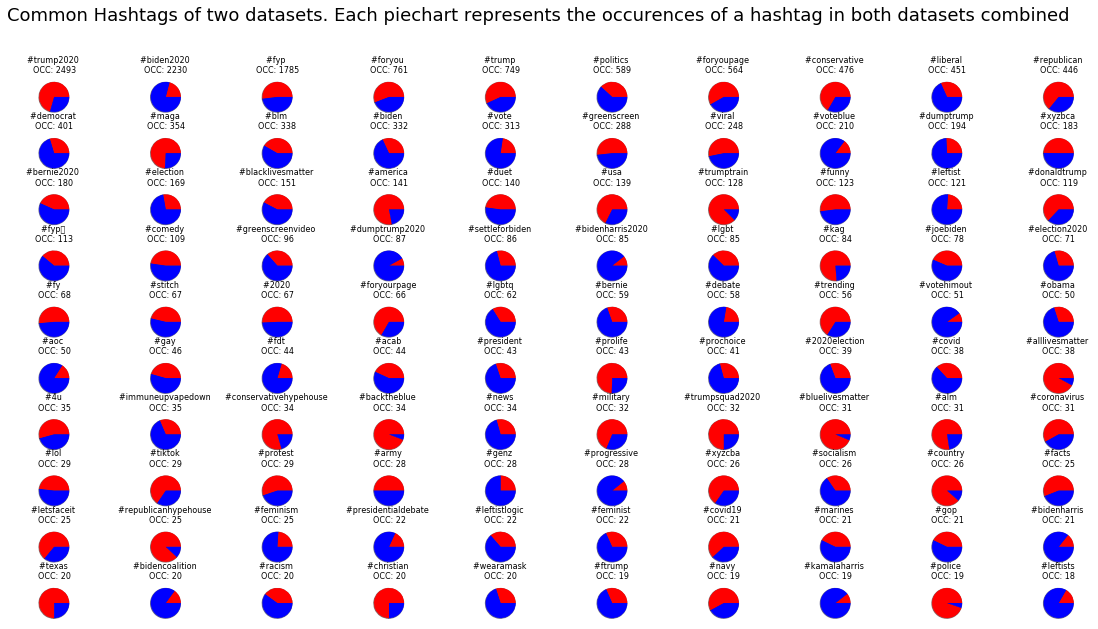

In [186]:
both = pd.concat([df_t,df_b])
n = 10
counts_both = both["hashtags"].value_counts().nlargest(n*n)

fig,axs = plt.subplots(n,n,figsize=(n*2, n), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.suptitle("Common Hashtags of two datasets. Each piechart represents the occurences of a hashtag in both datasets combined")
axs = axs.ravel()

for i,hashtag in enumerate(counts_both.index):
    t = counts_t[hashtag]
    b = counts_b[hashtag]
    axs[i].pie([t,b],colors=["red","blue"],shadow=True)
    axs[i].set_title("#"+hashtag+" \nOCC: "+str(counts_t[hashtag]+counts_b[hashtag]))
    axs[i].title.set_size(8)

plt.show()

In [187]:
import math as math
import scipy.stats as sps
from collections import defaultdict

n = 1000
dictA = dict(both[both["source"]=="trump"].hashtags.value_counts().nlargest(n))
dictB = dict(both[both["source"]=="biden"].hashtags.value_counts().nlargest(n))

sumValuesA = sum(dictA.values())
sumValuesB = sum(dictB.values())

dictAB = {key: (value, dictB.get(key)) for key, 
          value in dictA.items() if key in dictB.keys()}

df = pd.DataFrame(dictAB)
df = df.T
df.reset_index(level=0, inplace=True)
df.columns = ["source","trump","biden"]

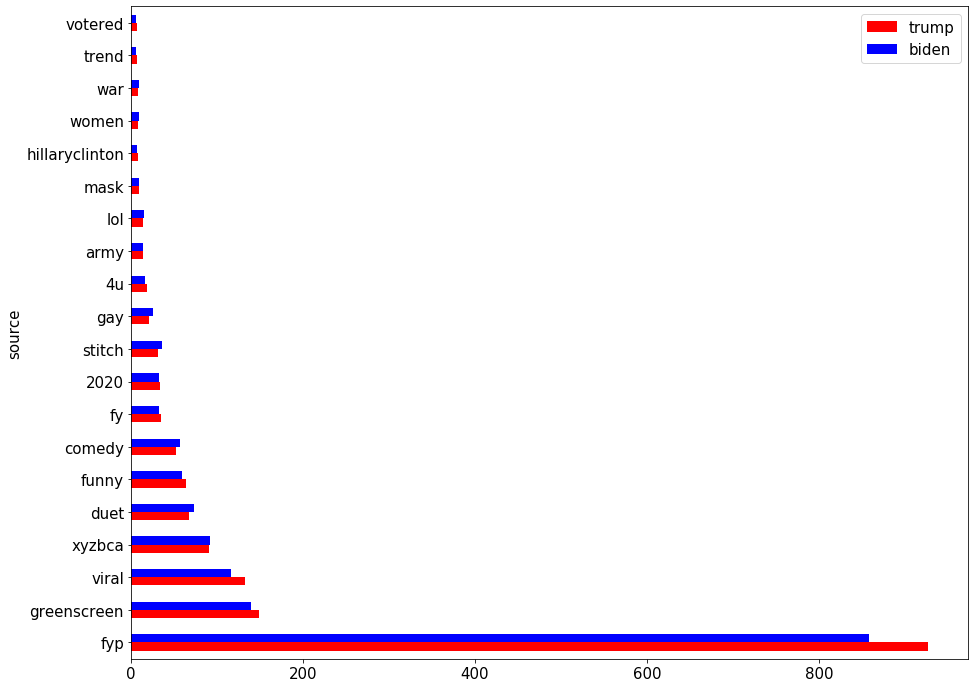

In [188]:
f = df.drop(df[abs((df.trump/(df.trump+df.biden)*100) - 50) > 5].index)
f.head(20).plot.barh(x="source", y=["trump","biden"], color=["red","blue"],figsize=(15,12))

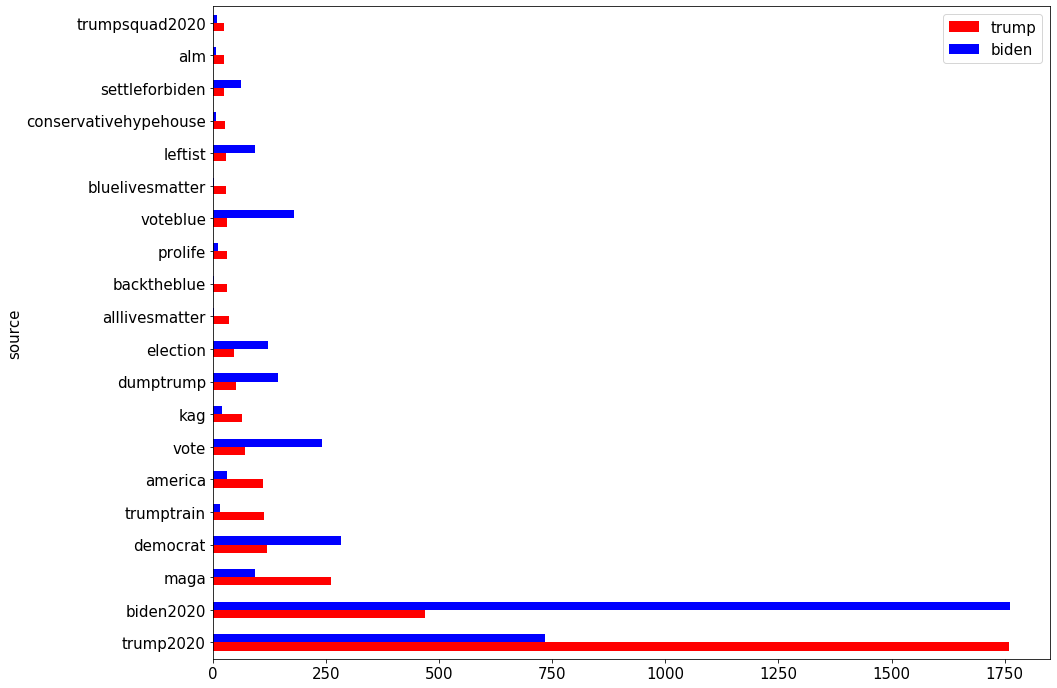

In [189]:
f = df.drop(df[abs((df.trump/(df.trump+df.biden)*100) - 50) < 20].index)
f.head(20).plot.barh(x="source", y=["trump","biden"], color=["red","blue"],figsize=(15,12))

<Figure size 432x288 with 0 Axes>

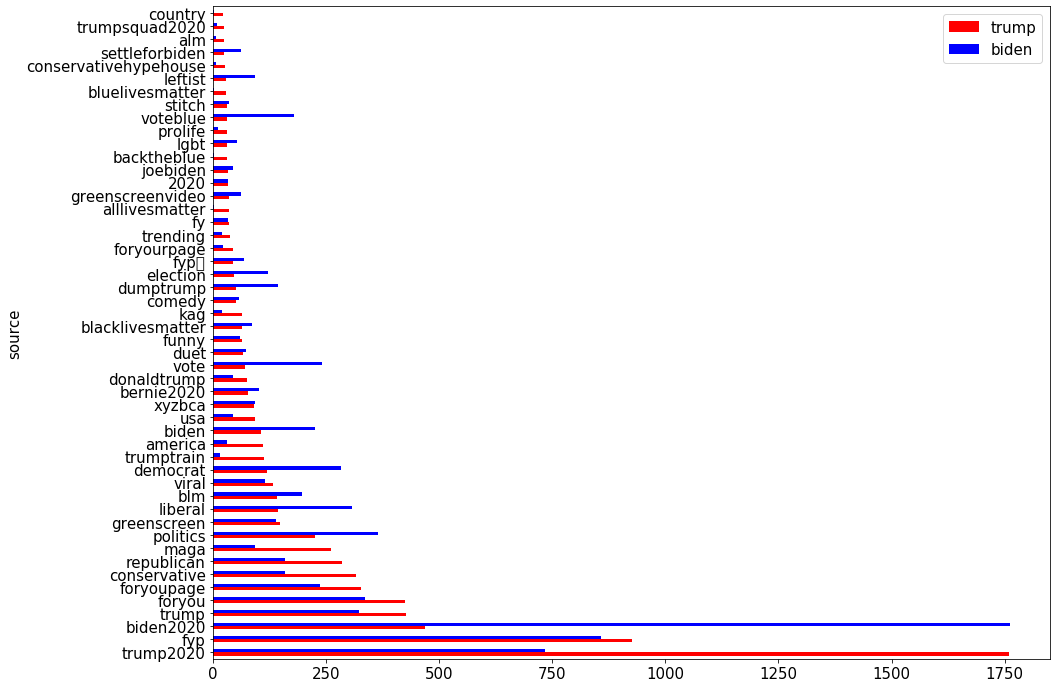

In [190]:
plt.figure()
plt.rcParams.update({'font.size': 15})
ax = df.head(50).plot(x="source", y=["trump","biden"], kind="barh",color=["red","blue"],figsize=(15,12))

In [68]:
both.to_csv("../data/processed/both.csv")

def fnDiffProp(x1, x2, n1, n2):
    '''
    inputs:
    x1: the number of successes in the first sample
    x2: the number of successes in the second sample
    n1: the total number of 'trials' in the first sample
    n2: the total number of 'trials' in the second sample
    output:
    the test statistic, and the p-value as a tuple
    '''
    hatP = (x1 + x2)/(n1 + n2)
    hatQ = 1 - hatP
    hatP1 = x1/n1
    hatP2 = x1/n2
    Z = (hatP1 - hatP2)/(math.sqrt(hatP*hatQ*(1/n1 + 1/n2)))
    pVal = 2*(1 - sps.norm.cdf(Z))
    return((Z, pVal))

# apply the function above to each of the common words across the
#     two samples
dictPropTest = {key: fnDiffProp(value[0], value[1],
                                 sumValuesA, sumValuesB) for key, value in dictAB.items() }